In [30]:
# Importing the libraries and removing the warning messages

import pandas as pd
import numpy as np
import warnings
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from statsmodels.tsa.stattools import acf, pacf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import *

warnings.filterwarnings('ignore')

In [2]:
# Importing the scripts

sys.path.append("..")
from scripts.data_vizualization import Data_Viz 
from scripts.data_cleaning import DataCleaner
from scripts.data_transformation import DataTransformer
from scripts.stationary_check import check_stationary_mv, check_stationary_adf,corrPlots
from scripts.deep_learning import model_forecast

DC = DataCleaner()
DV = Data_Viz()
DT = DataTransformer()

In [3]:
# Importing and reading the data

train = pd.read_csv('../data/train_data_clean.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 22 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  float64
 4   Customers                  1017209 non-null  float64
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1017209 non-null  float64
 12  CompetitionOpenSinceMonth  1017209 non-null  object 
 13  CompetitionO

In [4]:
# Checking out the index and changing it from object to date format and sorting the data by date

train['Date'] = pd.to_datetime(train['Date'])
train = train.sort_values(by='Date')
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,DayOfMonth,Weekday
1017208,1115,2,2013-01-01,0.0,0.0,0,0,Public Holiday,1,d,...,Not Available,Not Available,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2013,1,1,1
1016473,379,2,2013-01-01,0.0,0.0,0,0,Public Holiday,1,d,...,Not Available,Not Available,0,Not Available,Not Available,Not Available,2013,1,1,1
1016472,378,2,2013-01-01,0.0,0.0,0,0,Public Holiday,1,a,...,8.0,2012.0,0,Not Available,Not Available,Not Available,2013,1,1,1
1016471,377,2,2013-01-01,0.0,0.0,0,0,Public Holiday,1,a,...,6.0,2010.0,1,18.0,2010.0,"Feb,May,Aug,Nov",2013,1,1,1
1016470,376,2,2013-01-01,0.0,0.0,0,0,Public Holiday,1,a,...,8.0,2012.0,0,Not Available,Not Available,Not Available,2013,1,1,1


In [5]:
# Check if there is a missing value

DV.summ_columns(train)

,variables,missing_count,missing_percent_(%),data_type,unique_values
0,Store,0,0.0,int64,1115
1,DayOfWeek,0,0.0,int64,7
2,Date,0,0.0,datetime64[ns],942
3,Sales,0,0.0,float64,13194
4,Customers,0,0.0,float64,1423
5,Open,0,0.0,int64,2
6,Promo,0,0.0,int64,2
7,StateHoliday,0,0.0,object,4
8,SchoolHoliday,0,0.0,int64,2
9,StoreType,0,0.0,object,4


###### From the above we can see that the train dataset has no missing value

In [6]:
# Creating a sales per day dataframe

sales_per_day = train[['Date','Sales']].groupby(['Date']).agg({'Sales':'mean'})

sales_per_day.head()

,Sales
Date,
2013-01-01,76.857271
2013-01-02,6050.476233
2013-01-03,5577.322870
2013-01-04,5832.756054
2013-01-05,5178.539910


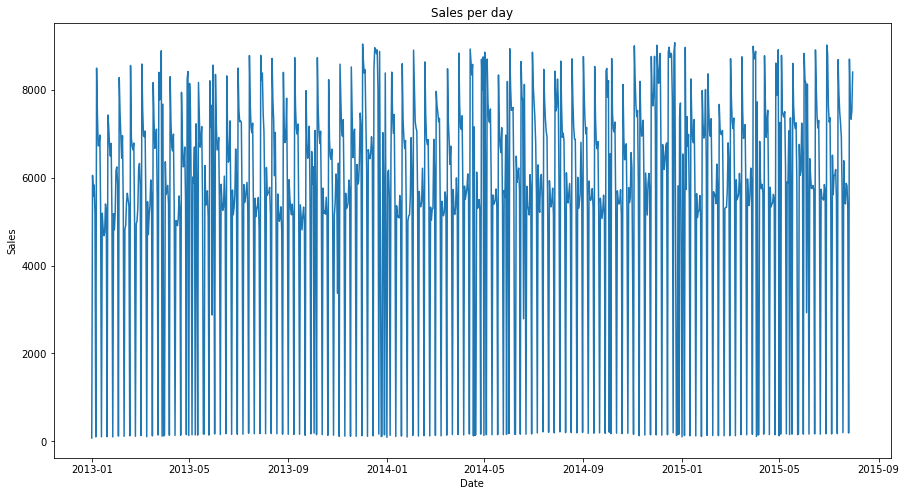

In [7]:
# Ploting the sales per day graph

DV.plot_line(sales_per_day, "Date", "Sales", [15, 8], "Sales per day", "sales_per_day.jpg")

##### From the above graph we can deduce that the data is more or less stationary with constant mean and std. But in the next section lets try to check its stationarity by using ADF

In [8]:
# Checking stationarity both by using ADF and mean value
check_stationary_mv(sales_per_day, "sales per days")
print('\n************')
check_stationary_adf(sales_per_day,"Sales", "sales per days")


sales per days

mean1= 5294.642044, mean2= 5510.146317, mean3= 5627.432265
variance1= 6335293.739971, variance2= 6919854.936390, variance3=7434693.765829

************

sales per days

ADF Statistic: -6.005160393292818
p-value: 1.622066162619138e-07


(-6.005160393292818,
 1.622066162619138e-07,
 21,
 920,
 {'1%': -3.4374778690219956,
  '5%': -2.864686684217556,
  '10%': -2.5684454926748583},
 16043.472197358595)

#### From the above metrixes we can see that the p-value is <0.05 and the mean and std are constant so we can say that the data is stationary.

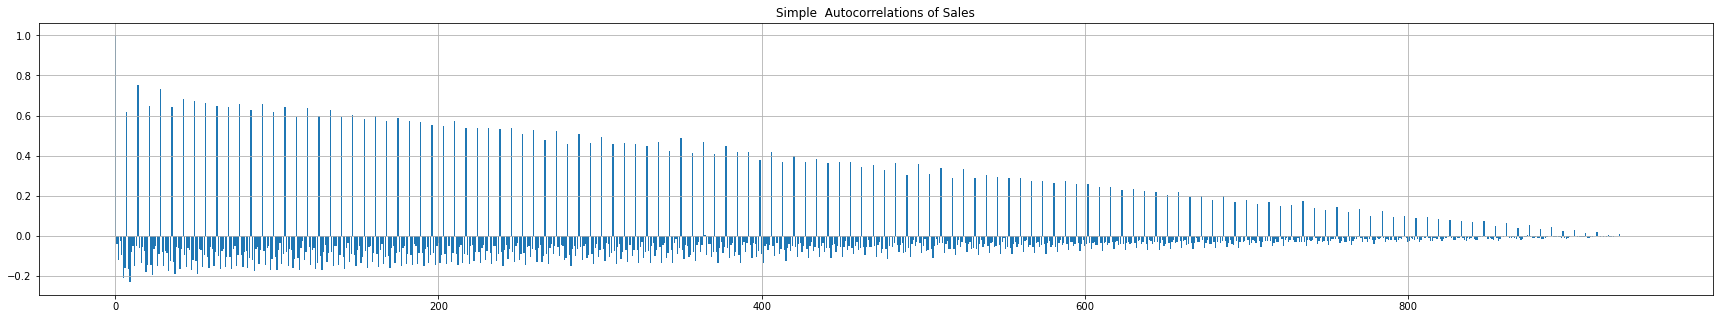

<Figure size 432x288 with 0 Axes>

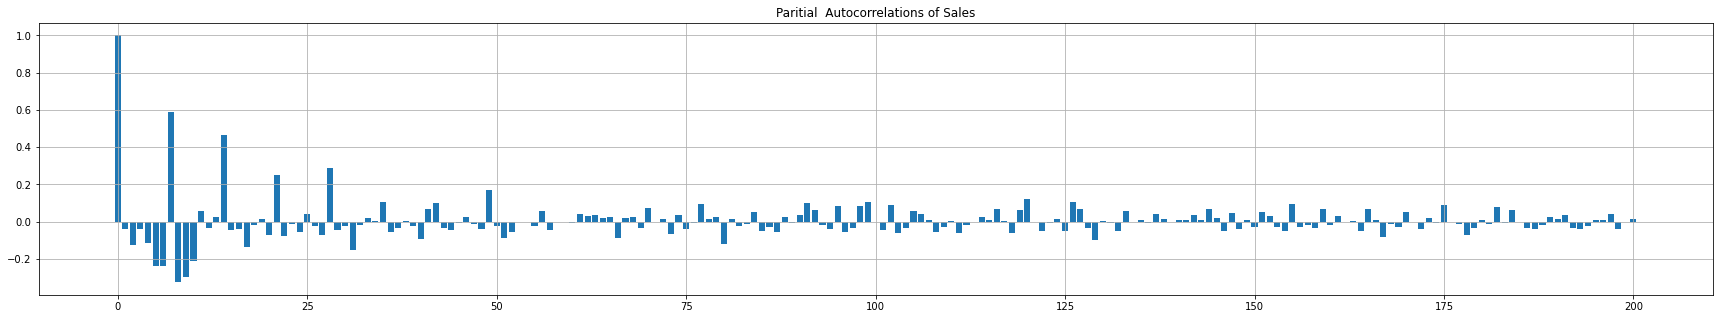

<Figure size 432x288 with 0 Axes>

In [9]:
# plotting autocorrelation graph for sales per day
acf_days = acf(sales_per_day.Sales.values, fft=True, nlags=941)
acfNp = np.array(acf_days)
pacf_days = pacf(sales_per_day.Sales.values, nlags=200)
pacfNp = np.array(pacf_days)

corrPlots(acfNp, 'Simple')
corrPlots(pacfNp, "Paritial")

##### From the above graph also we can see that the autocorrelation is having a constant pattern so we can say that the data is stationary

### Scaling the data

In [10]:
# scaling the data from -1 to 1 for the model fitting

scaler = MinMaxScaler()
scaler.fit(sales_per_day.Sales.values.reshape([-1, 1]))
SalesScaled = scaler.transform(sales_per_day.Sales.values.reshape(-1, 1))
sales_per_day['SalesScaled'] = SalesScaled
sales_per_day.tail(10)

,Sales,SalesScaled
Date,,
2015-07-22,5402.158744,0.592287
2015-07-23,5870.411659,0.644366
2015-07-24,5815.365022,0.638244
2015-07-25,5284.921973,0.579248
2015-07-26,191.102242,0.012706
2015-07-27,8694.100448,0.958421
2015-07-28,7742.983857,0.852636
2015-07-29,7326.593722,0.806325
2015-07-30,7510.558744,0.826786


In [11]:
# Checking the min max value for the scaled sales data

sales_per_day.describe()

,Sales,SalesScaled
count,942.000000,942.000000
mean,5477.406875,0.600656
std,2631.151367,0.292640
min,76.857271,0.000000
25%,5226.430053,0.572742
50%,5869.721338,0.644290
75%,7237.389961,0.796404
max,9067.943316,1.000000


##### From the above description we can see that the data is successfuly scaled between -1 and 1 but in our case 0 to 1

### Training and Validation set separation

In [12]:
SIZE = len(sales_per_day.SalesScaled)
WINDOW_SIZE = 48
BATCH_SIZE= SIZE-WINDOW_SIZE*2
EPOCHS = 200

In [13]:
DateTrain = sales_per_day.index.values[0:BATCH_SIZE]
DateValid = sales_per_day.index.values[BATCH_SIZE:]
XTrain = sales_per_day.SalesScaled.values[0:BATCH_SIZE].astype('float32')
XValid = sales_per_day.SalesScaled.values[BATCH_SIZE:].astype('float32')

# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set date series:  (846, 1)
Shape of the validation set date series:  (96, 1)

Shape of the training set logarithm of sales series:  (846,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (96,)


In [14]:
tf.random.set_seed(1234)
# add extra dimension
series = tf.expand_dims(XTrain, axis=-1)
series.shape

TensorShape([846, 1])

In [15]:
# create tensor from each individual element

dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

<TensorSliceDataset shapes: (1,), types: tf.float32>

In [16]:
# takes a window_size + 1 chunk from the slices
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True) 

In [17]:
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))

In [18]:
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

In [19]:
dataset = dataset.batch(BATCH_SIZE).prefetch(1)

In [20]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE): 
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) 
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [21]:
# Getting the train and validation dataset

DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)

In [22]:
# Creating the deep learning model

model = Sequential()
model.add(LSTM(8, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(4, input_shape=[None, 1]))
model.add(Dense(1))
model.compile(loss="huber_loss", optimizer='adam')

In [23]:
# Checking out the model summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 8)           320       
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Checking out the model history and life cycle since its output is very long I removed the output and display the snippet in the next cell

history = model.fit(DatasetTrain, epochs=EPOCHS, validation_data=DatasetVal, verbose=1)

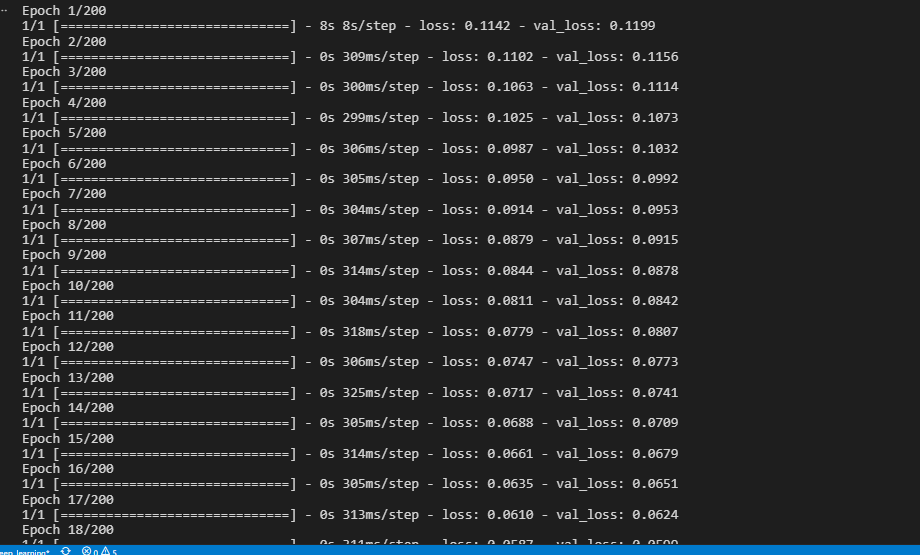

In [25]:
# The snippet of the above cell output

%matplotlib inline
from IPython.display import Image
Image('../charts/Capture.PNG')

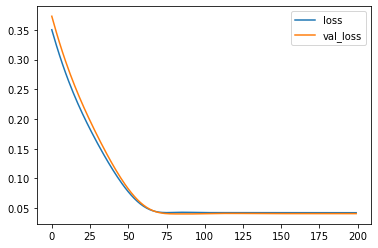

In [26]:
# Plotting the loss plot

fig = plt.figure()
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.savefig('../charts/deep_learning_model_loss.jpg')
plt.show()

### Finding out the accuracy of the model by using the validation set

In [27]:
Forecast = model_forecast(model, sales_per_day.SalesScaled.values[:, np.newaxis], WINDOW_SIZE, SIZE)
Results = Forecast[BATCH_SIZE-WINDOW_SIZE:-1]
Results1 = scaler.inverse_transform(Results.reshape(-1,1))
XValid1 = scaler.inverse_transform(XValid.reshape(-1,1))

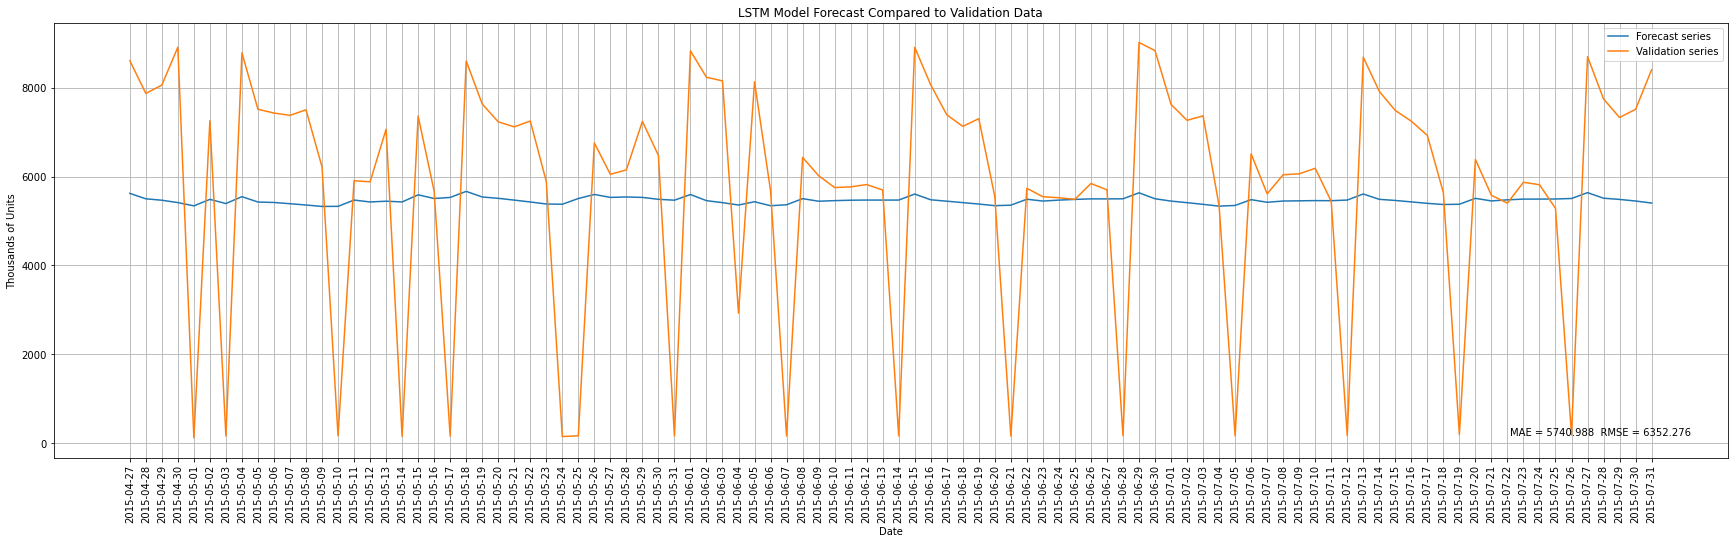

MAE = 5740.988  RMSE = 6352.276


In [28]:
plt.figure(figsize=(30, 8))
plt.title("LSTM Model Forecast Compared to Validation Data")
plt.plot(DateValid.astype('datetime64'), Results1, label='Forecast series')
plt.plot(DateValid.astype('datetime64'), np.reshape(XValid1, (2*WINDOW_SIZE, 1)), label='Validation series')
plt.xlabel('Date')
plt.ylabel('Thousands of Units')
plt.xticks(DateValid.astype('datetime64')[:,-1], rotation = 90) 
plt.legend(loc="upper right")

MAE = tf.keras.metrics.mean_absolute_error(XValid1[:,-1], Results[:,-1]).numpy()
RMSE = np.sqrt(tf.keras.metrics.mean_squared_error(XValid1[:,-1], Results[:,-1]).numpy())

textstr = "MAE = " + "{:.3f}".format(MAE) + "  RMSE = " + "{:.3f}".format(RMSE)

# place a text box in upper left in axes coords
plt.annotate(textstr, xy=(0.87, 0.05), xycoords='axes fraction')
plt.grid(True)

plt.show()
print(textstr)

In [31]:
# Finding out the current date and time for our serialization naming

now = datetime.now()
formated_date = now.strftime("%Y-%m-%d-%H-%M-%S")
formated_date

'2022-05-28-12-36-36'

In [32]:
# Creating a file name using the formated time

file_path = "../models/LSTM-mod-"+str(formated_date)+'.pkl'
file_path

'../models/LSTM-mod-2022-05-28-12-36-36.pkl'

In [36]:
# Serializing or dumping using pkl loader

model.save(file_path)

INFO:tensorflow:Assets written to: ../models/LSTM-mod-2022-05-28-12-36-36.pkl\assets


INFO:tensorflow:Assets written to: ../models/LSTM-mod-2022-05-28-12-36-36.pkl\assets
